In [7]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [8]:
train_files, train_targets = load_dataset('data/train')
valid_files, valid_targets = load_dataset('data/valid')
test_files, test_targets = load_dataset('data/test')

In [9]:
from os import listdir

diseases = sorted(listdir('data/train'))

print('There are {} classes: {}.'.format(len(diseases), ', '.join(diseases)))
print('There are {} training images.'.format(len(train_files)))
print('There are {} validation images.'.format(len(valid_files)))
print('There are {} testing images.'.format(len(test_files)))

There are 3 classes: melanoma, nevus, seborrheic_keratosis.
There are 2000 training images.
There are 150 validation images.
There are 594 testing images.


In [10]:
from keras.preprocessing import image
from tqdm import tqdm_notebook

def get_tensor(path):
#     print(path)
    img = image.load_img(path, target_size=(224, 224))
    return np.expand_dims(image.img_to_array(img), axis=0)

def get_tensors(paths):
    return np.vstack([get_tensor(path) for path in tqdm_notebook(paths)])

In [11]:
from keras.applications.resnet50 import preprocess_input

train_tensors = preprocess_input(get_tensors(train_files))
valid_tensors = preprocess_input(get_tensors(valid_files))

In [12]:
test_tensors = preprocess_input(get_tensors(test_files))

In [13]:
from keras.applications.resnet50 import ResNet50
resnet50 = ResNet50(include_top=False, input_shape=(224, 224, 3))

In [14]:
train_bottleneck = resnet50.predict(train_tensors, batch_size=1)
valid_bottleneck = resnet50.predict(valid_tensors, batch_size=1)
test_bottleneck = resnet50.predict(test_tensors, batch_size=1)

In [15]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_bottleneck.shape[1:]))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='tanh'))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6147      
Total params: 8,398,851.0
Trainable params: 8,398,851.0
Non-trainable params: 0.0
____________________________________________________________

In [16]:
from keras import optimizers
model.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer = optimizers.SGD(lr=0.0001, momentum=0.9, decay=1e-6))

In [17]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='resnet.from.bottleneck.hdf5', save_best_only=True)
history = model.fit(train_bottleneck, train_targets, epochs=100,
          validation_data=(valid_bottleneck, valid_targets),
          callbacks=[checkpointer], verbose=1, shuffle=True, batch_size = 8)

Train on 2000 samples, validate on 150 samples
Epoch 1/100
2000/2000 [==============================] - 2s - loss: 0.8989 - acc: 0.6295 - val_loss: 1.3123 - val_acc: 0.5267
Epoch 2/100
2000/2000 [==============================] - 2s - loss: 0.7948 - acc: 0.6695 - val_loss: 1.2380 - val_acc: 0.5400
Epoch 3/100
2000/2000 [==============================] - 2s - loss: 0.7742 - acc: 0.6785 - val_loss: 0.9695 - val_acc: 0.6133
Epoch 4/100
2000/2000 [==============================] - 2s - loss: 0.7351 - acc: 0.6875 - val_loss: 0.8610 - val_acc: 0.6800
Epoch 5/100
2000/2000 [==============================] - 2s - loss: 0.7320 - acc: 0.6940 - val_loss: 0.8392 - val_acc: 0.6867
Epoch 6/100
2000/2000 [==============================] - 2s - loss: 0.6983 - acc: 0.7115 - val_loss: 0.8748 - val_acc: 0.6867
Epoch 7/100
2000/2000 [==============================] - 2s - loss: 0.6987 - acc: 0.7025 - val_loss: 0.8809 - val_acc: 0.6733
Epoch 8/100
2000/2000 [==============================] - 2s - loss: 0.6

2000/2000 [==============================] - 2s - loss: 0.5857 - acc: 0.7500 - val_loss: 0.8264 - val_acc: 0.6933
Epoch 66/100
2000/2000 [==============================] - 2s - loss: 0.5752 - acc: 0.7490 - val_loss: 0.7464 - val_acc: 0.7000
Epoch 67/100
2000/2000 [==============================] - 2s - loss: 0.5773 - acc: 0.7500 - val_loss: 0.7980 - val_acc: 0.6933
Epoch 68/100
2000/2000 [==============================] - 2s - loss: 0.5903 - acc: 0.7415 - val_loss: 0.8520 - val_acc: 0.7067
Epoch 69/100
2000/2000 [==============================] - 2s - loss: 0.5710 - acc: 0.7565 - val_loss: 0.8172 - val_acc: 0.7067
Epoch 70/100
2000/2000 [==============================] - 2s - loss: 0.5886 - acc: 0.7565 - val_loss: 0.8389 - val_acc: 0.7067
Epoch 71/100
2000/2000 [==============================] - 1s - loss: 0.5927 - acc: 0.7560 - val_loss: 0.8018 - val_acc: 0.7000
Epoch 72/100
2000/2000 [==============================] - 2s - loss: 0.5706 - acc: 0.7525 - val_loss: 0.7283 - val_acc: 0.72

In [19]:
model.load_weights('resnet.from.bottleneck.hdf5')

In [20]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*model.evaluate(test_bottleneck, test_targets)))

544/594 [==========================>...] - ETA: 0s
Testing loss: 0.7021
Testing accuracy: 0.7273


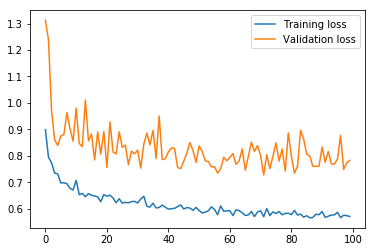

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

AUC for melanoma: 0.7606
AUC for nevus: 0.8494
AUC for seborrheic_keratosis: 0.9004


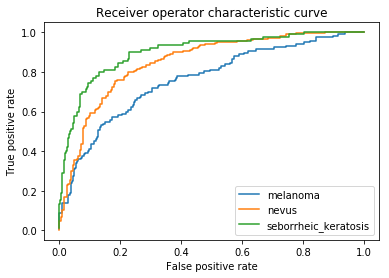

In [22]:
from sklearn.metrics import roc_curve, auc

for i in range(len(diseases)):
    fpr, tpr, _ = roc_curve(test_targets[:,i], model.predict(test_bottleneck)[:,i])
    print('AUC for {}: {:.4f}'.format(diseases[i], auc(fpr, tpr)))
    plt.plot(fpr, tpr, label=diseases[i])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('Receiver operator characteristic curve')
plt.show()

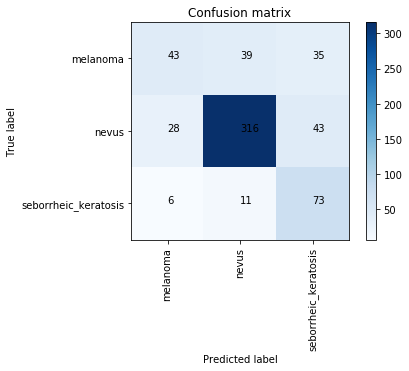

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(test_targets, axis=1),
                      np.argmax(model.predict(test_bottleneck), axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(diseases))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, diseases, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, diseases)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [24]:
import csv

with open('predictions.csv', 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(['Id', 'task_1', 'task_2'])
    for path in tqdm_notebook(sorted(test_files)):
        tensor = preprocess_input(get_tensor(path))
        pred = model.predict(resnet50.predict(tensor))[0]
        csvwriter.writerow([path, pred[0], pred[2]])

In [28]:
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

In [26]:
train_bottleneck = vgg16.predict(train_tensors)
valid_bottleneck = vgg16.predict(valid_tensors)
test_bottleneck = vgg16.predict(test_tensors)

In [29]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_bottleneck.shape[1:]))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='tanh'))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 6147      
Total params: 8,398,851.0
Trainable params: 8,398,851.0
Non-trainable params: 0.0
____________________________________________________________

In [30]:

from keras import optimizers

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer=optimizers.SGD(lr=0.0001, momentum=0.9, decay=1e-6))

In [31]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='vgg16.from.bottleneck.hdf5', save_best_only=True)
history = model.fit(train_bottleneck, train_targets, epochs=100,
          validation_data=(valid_bottleneck, valid_targets),
          callbacks=[checkpointer], verbose=1, shuffle=True)

Train on 2000 samples, validate on 150 samples
Epoch 1/100
2000/2000 [==============================] - 1s - loss: 0.9855 - acc: 0.5965 - val_loss: 1.1784 - val_acc: 0.5200
Epoch 2/100
2000/2000 [==============================] - 0s - loss: 0.8754 - acc: 0.6340 - val_loss: 1.1303 - val_acc: 0.5267
Epoch 3/100
2000/2000 [==============================] - 0s - loss: 0.8183 - acc: 0.6455 - val_loss: 1.2281 - val_acc: 0.5267
Epoch 4/100
2000/2000 [==============================] - 0s - loss: 0.8164 - acc: 0.6545 - val_loss: 1.0110 - val_acc: 0.5600
Epoch 5/100
2000/2000 [==============================] - 0s - loss: 0.7981 - acc: 0.6640 - val_loss: 0.9372 - val_acc: 0.5733
Epoch 6/100
2000/2000 [==============================] - 0s - loss: 0.7870 - acc: 0.6800 - val_loss: 1.0370 - val_acc: 0.5733
Epoch 7/100
2000/2000 [==============================] - 0s - loss: 0.7756 - acc: 0.6725 - val_loss: 0.9579 - val_acc: 0.5867
Epoch 8/100
2000/2000 [==============================] - 0s - loss: 0.7

2000/2000 [==============================] - 0s - loss: 0.6213 - acc: 0.7295 - val_loss: 0.8105 - val_acc: 0.6933
Epoch 66/100
2000/2000 [==============================] - 0s - loss: 0.6226 - acc: 0.7295 - val_loss: 0.8426 - val_acc: 0.6933
Epoch 67/100
2000/2000 [==============================] - 0s - loss: 0.6248 - acc: 0.7350 - val_loss: 0.8058 - val_acc: 0.7067
Epoch 68/100
2000/2000 [==============================] - 0s - loss: 0.6290 - acc: 0.7325 - val_loss: 0.8320 - val_acc: 0.6800
Epoch 69/100
2000/2000 [==============================] - 0s - loss: 0.6293 - acc: 0.7265 - val_loss: 0.7861 - val_acc: 0.7133
Epoch 70/100
2000/2000 [==============================] - 0s - loss: 0.6250 - acc: 0.7360 - val_loss: 0.7811 - val_acc: 0.7000
Epoch 71/100
2000/2000 [==============================] - 0s - loss: 0.6182 - acc: 0.7315 - val_loss: 0.7984 - val_acc: 0.6933
Epoch 72/100
2000/2000 [==============================] - 0s - loss: 0.6262 - acc: 0.7315 - val_loss: 0.8031 - val_acc: 0.70

In [32]:
model.load_weights('vgg16.from.bottleneck.hdf5')

In [33]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*model.evaluate(test_bottleneck, test_targets)))

512/594 [========================>.....] - ETA: 0s
Testing loss: 0.6421
Testing accuracy: 0.7508


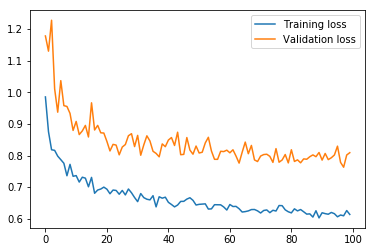

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

AUC for melanoma: 0.7706
AUC for nevus: 0.8488
AUC for seborrheic_keratosis: 0.8975


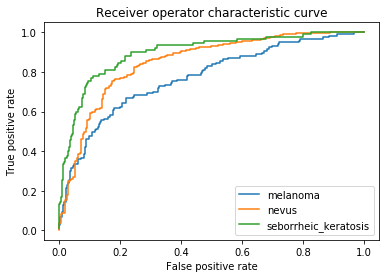

In [35]:
from sklearn.metrics import roc_curve, auc

for i in range(len(diseases)):
    fpr, tpr, _ = roc_curve(test_targets[:,i], model.predict(test_bottleneck)[:,i])
    print('AUC for {}: {:.4f}'.format(diseases[i], auc(fpr, tpr)))
    plt.plot(fpr, tpr, label=diseases[i])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('Receiver operator characteristic curve')
plt.show()

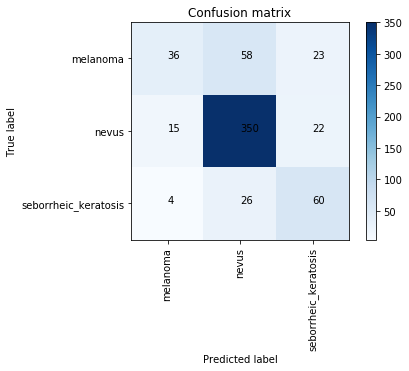

In [36]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(test_targets, axis=1),
                      np.argmax(model.predict(test_bottleneck), axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(diseases))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, diseases, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, diseases)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [37]:
import csv

with open('predictionsVgg16.csv', 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(['Id', 'task_1', 'task_2'])
    for path in tqdm_notebook(sorted(test_files)):
        tensor = preprocess_input(get_tensor(path))
        pred = model.predict(resnet50.predict(tensor))[0]
        csvwriter.writerow([path, pred[0], pred[2]])